In [1]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy import signal as sg
import obspy

# Adjustable parameters are here.

In [2]:
# Radius of the world.
r_earth = 6371e6

# Radius of the observation.
obs_radius = 2.0

# Minimum detection magnitude.
obs_min_magnitude = 2.5

# Station code name.
obs_station = "CTKS"

# Event window.
obs_event_window_start = -30
obs_event_window_end = 330

# N, E, Z components can be entered.
obs_components = ["N"]

# Imaginary station positions with respect to center station(CTKS).
station_a_lat_diff = 0.21
station_a_long_diff = -0.21
station_b_lat_diff = 0.21
station_b_long_diff = 0.0
station_c_lat_diff = 0.21
station_c_long_diff = 0.21
station_d_lat_diff = -0.21
station_d_long_diff = 0.21
station_e_lat_diff = -0.21
station_e_long_diff = 0.0
station_f_lat_diff = -0.21
station_f_long_diff = -0.21

# Exhibition duration(in seconds; 30min in our case.)
exhibition_duration_in_secs = 1800

# Output saturation coefficient; controls the steepness of the output function.
audio_saturation_coeff = 25.0
audio_noise_coeff = 2.0
lighting_saturation_coeff = 50.0
lighting_noise_coeff = 3.0
vibration_saturation_coeff = 3.0
vibration_on_threshold = 0.75

# Start and end time of data acquisition.
obs_start_time = UTCDateTime("2020-01-01T00:00:00.000")
obs_end_time = UTCDateTime("2020-12-31T23:59:59.900")

# Start and end time of the noise sample acquisition. 
obs_noise_start_time = UTCDateTime("2020-06-01T00:00:00.000")
obs_noise_end_time = UTCDateTime("2020-06-02T23:59:00.000")

# This parameters should be kept as is!

In [3]:
station_sampling_freq = 100.0
output_sampling_freq = 4096
lighting_sampling_freq = 64
audio_sampling_freq = output_sampling_freq

### Get station data from the local memory.

In [4]:
from obspy import read_inventory

client = Client("KOERI")
inv = client.get_stations(network="KO", station=obs_station, starttime=obs_start_time, endtime=obs_end_time, 
                          channel="*", level="response")
station = client.get_stations(station=obs_station)

### Get event catalog.

In [5]:
client = Client("EMSC")
evt_catalog = client.get_events(starttime=obs_start_time, endtime=obs_end_time, 
                       latitude=station[0][0].latitude, longitude=station[0][0].longitude, maxradius=obs_radius, minmagnitude=obs_min_magnitude)

### Put events into a list and sort them with respect to time. 

In [6]:
def sortingmeasure(event):
    return event.origins[0].time

evts = []
for evt in evt_catalog:
    evts.append(evt)
    
evts.sort(key=sortingmeasure, reverse=False)

### Get streams related to the events in the catalog.

In [7]:
client=Client("KOERI")
streams = []

for i in range(0, len(evts)):
    real_tevt = evts[i].origins[0].time
    
    noexcept = True
    st = obspy.core.Stream()
    
    try:
        st = client.get_waveforms("KO", obs_station, "*", "*", (real_tevt+obs_event_window_start), (real_tevt+obs_event_window_end))
    except:
        print("No data exception at " + str(real_tevt))
        noexcept = False
        streams.append(None)
        
    if noexcept:
        streams.append(st)

No data exception at 2020-07-06T03:45:28.900000Z


### Preprocess streams; by merging, detrending, filtering and removing the station response.

In [8]:
for st in streams:
    if st != None:
        st.merge(fill_value = 0)
        st.detrend(type="linear")
        st.filter("bandpass", freqmin=0.005, freqmax=25.0).remove_response(inventory=inv)

### Distance and weight calculation for different imaginary stations.

In [9]:
import math

def distance(lat1, long1, ele1, lat2, long2, ele2):
    lat1 = lat1 * math.pi/180.0
    lat2 = lat2 * math.pi/180.0
    long1 = long1 * math.pi/180.0
    long2 = long2 * math.pi/180.0
    
    x1 = (r_earth + ele1) * math.cos(lat1) * math.cos(long1)
    y1 = (r_earth + ele1) * math.cos(lat1) * math.sin(long1)
    z1 = (r_earth + ele1) * math.sin(lat1)
    x2 = (r_earth + ele2) * math.cos(lat2) * math.cos(long2)
    y2 = (r_earth + ele2) * math.cos(lat2) * math.sin(long2)
    z2 = (r_earth + ele2) * math.sin(lat2)
    
    return (((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)**0.5)

def weigth(lat_diff, long_diff, event_lat, event_long, event_depth):
    coord = inv.get_coordinates("KO." + obs_station + "..HHN")
    dbase2event = distance(coord['latitude'], coord['longitude'], coord['elevation'], event_lat, 
                           event_long, -event_depth)
    dsta2event = distance(coord['latitude']+lat_diff, coord['longitude']+long_diff, coord['elevation'], event_lat, 
                           event_long, -event_depth)
    
    return ((dbase2event/dsta2event)**2)

### Create vectors for different channels by merging the event data.

In [10]:
import numpy as np
from math import floor as flr
from copy import deepcopy

audio_vector = np.zeros(exhibition_duration_in_secs * output_sampling_freq)
lamp_a_vector = np.zeros(exhibition_duration_in_secs * output_sampling_freq)
lamp_b_vector = np.zeros(exhibition_duration_in_secs * output_sampling_freq)
lamp_c_vector = np.zeros(exhibition_duration_in_secs * output_sampling_freq)
lamp_d_vector = np.zeros(exhibition_duration_in_secs * output_sampling_freq)
lamp_e_vector = np.zeros(exhibition_duration_in_secs * output_sampling_freq)
lamp_f_vector = np.zeros(exhibition_duration_in_secs * output_sampling_freq)
vibration_vector = np.zeros(exhibition_duration_in_secs * output_sampling_freq)

for i in range(0, len(evts)):
    st = streams[i]
    
    if (st == None):
        continue
        
    cumulative_data = np.zeros(len(st.select(component=obs_components[0])[0].data))
    
    for __component in obs_components:
        tr_data = deepcopy(st.select(component=__component)[0].data)
        
        if len(cumulative_data) > len(tr_data):
            tr_data.resize(cumulative_data.shape)
        elif len(cumulative_data) < len(tr_data):
            cumulative_data.resize(tr_data.shape)
        
        cumulative_data = cumulative_data + tr_data
        
    event_vector = np.zeros(exhibition_duration_in_secs * output_sampling_freq)
    start_idx = flr(exhibition_duration_in_secs * audio_sampling_freq * ((st[0].meta.starttime.timestamp - obs_start_time.timestamp) / (obs_end_time.timestamp - obs_start_time.timestamp)))
    event_vector[start_idx:start_idx+len(cumulative_data)] = cumulative_data 
    
    event_lat = evts[i].origins[0].latitude
    event_long = evts[i].origins[0].longitude
    event_depth = evts[i].origins[0].depth
    
    lamp_a_vector = lamp_a_vector + event_vector * weigth(station_a_lat_diff, station_a_long_diff, event_lat, event_long, event_depth)
    lamp_b_vector = lamp_b_vector + event_vector * weigth(station_b_lat_diff, station_b_long_diff, event_lat, event_long, event_depth)
    lamp_c_vector = lamp_c_vector + event_vector * weigth(station_c_lat_diff, station_c_long_diff, event_lat, event_long, event_depth)
    lamp_d_vector = lamp_d_vector + event_vector * weigth(station_d_lat_diff, station_d_long_diff, event_lat, event_long, event_depth)
    lamp_e_vector = lamp_e_vector + event_vector * weigth(station_e_lat_diff, station_e_long_diff, event_lat, event_long, event_depth)
    lamp_f_vector = lamp_f_vector + event_vector * weigth(station_f_lat_diff, station_f_long_diff, event_lat, event_long, event_depth)
    
    vibration_vector = vibration_vector + event_vector
    audio_vector = audio_vector + event_vector

### Precondition noise data.

In [11]:
obs_noise_wdw = exhibition_duration_in_secs * audio_sampling_freq / station_sampling_freq

noise_st = client.get_waveforms("KO", obs_station, "*", "*", obs_noise_start_time, obs_noise_end_time)
noise_st.merge(fill_value = 0)
noise_st.detrend(type="linear")
noise_st.filter("bandpass", freqmin=0.005, freqmax=25.0).remove_response(inventory=inv)

3 Trace(s) in Stream:
KO.CTKS..HHE | 2020-06-01T00:00:00.000000Z - 2020-06-02T23:59:00.000000Z | 100.0 Hz, 17274001 samples
KO.CTKS..HHN | 2020-06-01T00:00:00.000000Z - 2020-06-02T23:59:00.000000Z | 100.0 Hz, 17274001 samples
KO.CTKS..HHZ | 2020-06-01T00:00:00.000000Z - 2020-06-02T23:59:00.000000Z | 100.0 Hz, 17274001 samples

### Create sample noise vector.

In [12]:
cumulative_data = np.zeros(len(noise_st.select(component=obs_components[0])[0].data))
    
for __component in obs_components:
    tr_data = deepcopy(noise_st.select(component=__component)[0].data)
        
    if len(cumulative_data) > len(tr_data):
        tr_data.resize(cumulative_data.shape)
    elif len(cumulative_data) < len(tr_data):
        cumulative_data.resize(tr_data.shape)
        
    cumulative_data = cumulative_data + tr_data
        
noise_sample_vector = deepcopy(cumulative_data)

### Gets a sample noise vector; and creates a randomized one with the same frequency spectrum.

In [13]:
def get_noise(sample_noise_vector, vlen):
    N = len(sample_noise_vector)
    N = N - (N%2)
    fftdata = np.fft.rfft(sample_noise_vector[0:N])
    N_2 = N >> 1
    phase_noise = 2 * np.pi * np.random.rand(N_2)
    fftdata[1:(N_2+1)] = fftdata[1:(N_2+1)] * np.exp(1j * phase_noise)
    return (np.real(np.fft.irfft(fftdata))[0:vlen])

### Create ready-to-run data. Add noise, decimate lower sampling channels and pass through a saturation function(tanh).

In [14]:
from scipy.signal import decimate

nsv = noise_sample_vector
lnc = lighting_noise_coeff
vlen = exhibition_duration_in_secs * output_sampling_freq

# Add noise to audio.
audio_vector = audio_vector + get_noise(nsv, vlen) * audio_noise_coeff

# Add noise to different lamp vectors and get the decimated vector.
lamp_a_vector = np.clip(decimate(decimate(np.absolute(lamp_a_vector + get_noise(nsv, vlen) * lnc), 8), 8), 0, None)
lamp_b_vector = np.clip(decimate(decimate(np.absolute(lamp_b_vector + get_noise(nsv, vlen) * lnc), 8), 8), 0, None)
lamp_c_vector = np.clip(decimate(decimate(np.absolute(lamp_c_vector + get_noise(nsv, vlen) * lnc), 8), 8), 0, None)
lamp_d_vector = np.clip(decimate(decimate(np.absolute(lamp_d_vector + get_noise(nsv, vlen) * lnc), 8), 8), 0, None)
lamp_e_vector = np.clip(decimate(decimate(np.absolute(lamp_e_vector + get_noise(nsv, vlen) * lnc), 8), 8), 0, None)
lamp_f_vector = np.clip(decimate(decimate(np.absolute(lamp_f_vector + get_noise(nsv, vlen) * lnc), 8), 8), 0, None)
vibration_vector = np.clip(decimate(decimate(decimate(decimate(np.absolute(vibration_vector), 8), 8), 8), 8), 0, None)

norm = max([np.amax(lamp_a_vector), np.amax(lamp_b_vector), np.amax(lamp_c_vector),
         np.amax(lamp_d_vector), np.amax(lamp_e_vector), np.amax(lamp_f_vector)])

# Post vectors as to be represented by the output units.
audio_vector_out = np.tanh(audio_saturation_coeff * audio_vector / np.amax(np.absolute(audio_vector)))
lamp_a_vector_out = np.tanh(lighting_saturation_coeff * lamp_a_vector / norm)
lamp_b_vector_out = np.tanh(lighting_saturation_coeff * lamp_b_vector / norm)
lamp_c_vector_out = np.tanh(lighting_saturation_coeff * lamp_c_vector / norm)
lamp_d_vector_out = np.tanh(lighting_saturation_coeff * lamp_d_vector / norm)
lamp_e_vector_out = np.tanh(lighting_saturation_coeff * lamp_e_vector / norm)
lamp_f_vector_out = np.tanh(lighting_saturation_coeff * lamp_f_vector / norm)
vibration_vector_out = np.int_(np.tanh(vibration_saturation_coeff * vibration_vector / 
                               np.amax(np.absolute(vibration_vector))) > vibration_on_threshold)

### Plot lighting vectors.

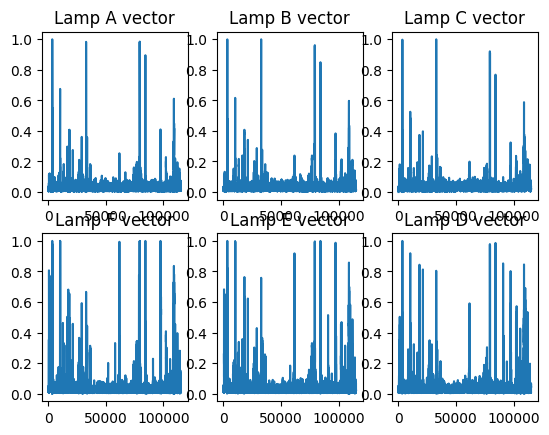

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3)
axs[0, 0].plot(lamp_a_vector_out)
axs[0, 0].set_title('Lamp A vector')
axs[0, 1].plot(lamp_b_vector_out)
axs[0, 1].set_title('Lamp B vector')
axs[0, 2].plot(lamp_c_vector_out)
axs[0, 2].set_title('Lamp C vector')
axs[1, 2].plot(lamp_d_vector_out)
axs[1, 2].set_title('Lamp D vector')
axs[1, 1].plot(lamp_e_vector_out)
axs[1, 1].set_title('Lamp E vector')
axs[1, 0].plot(lamp_f_vector_out)
axs[1, 0].set_title('Lamp F vector')

plt.show()

### Plot audio vector.

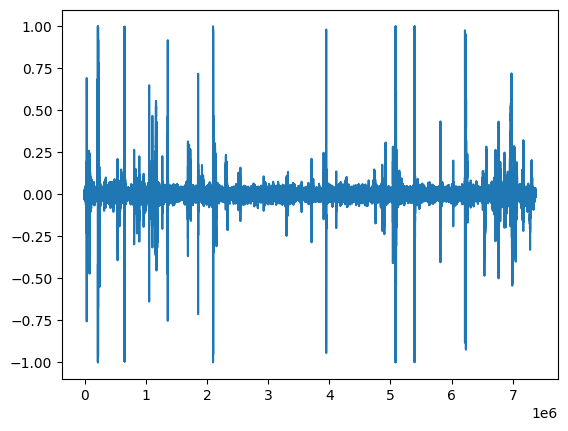

In [16]:
plt.plot(audio_vector_out)
plt.show()

### Write power binary file.

In [17]:
dlen = exhibition_duration_in_secs * lighting_sampling_freq

vibration_matrix = np.repeat(vibration_vector_out.reshape((len(vibration_vector_out), 1)), 64, axis=1)
upsampled_vibration_vector=vibration_matrix.reshape((len(vibration_vector_out) * 64))

power_channels = 255 * np.array([lamp_a_vector_out, lamp_b_vector_out, lamp_c_vector_out, lamp_d_vector_out, lamp_e_vector_out, lamp_f_vector_out, upsampled_vibration_vector, np.zeros(dlen)])
power_channels = power_channels.transpose()

f2 = open("./power.bin", "w")
power_channels.astype('u1').tofile(f2, sep="")
f2.close()

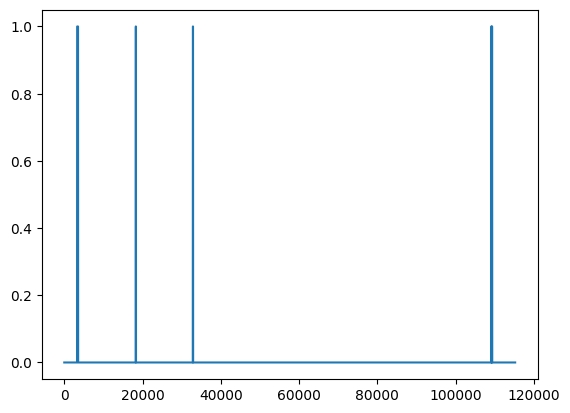

In [18]:
plt.plot(upsampled_vibration_vector)
plt.show()

### Write audio binary file.

In [19]:
f1 = open("audio.bin", "w")
audio = (0.999 * audio_vector_out + 1.0) * 2047
audio.astype('<u2').tofile(f1, sep="")
f1.close()

### Write wav file.

In [20]:
from scipy.io.wavfile import write
scaled = np.int16(audio_vector_out * 32727)
write('./audio.wav', audio_sampling_freq, scaled)